# Programming for Data Science and Artificial Intelligence

## Deep Learning - NLP + TorchText + Embedding

Here we shall improve the previous one by adding:

Improve the learning
- pre-trained word embeddings (**) (improve accuracy by around 20)
- changed optimizer to Adam (make the thing learn faster)
- orthogonal initialization (not significant improvements but certainly the choice in RNN/LSTM or even CNN!)

Improve efficiency
- packed padded sequences in RNN to save computations and also ask the RNN to ignore padding (++) (this is the deal breaker; without this, my accuracy is 50) (https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch)
- put padding_idx in embedding layer to save computations (no hit to accuracy but good practice to do)

In [1]:
import torchtext
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


### Loading the dataset

In [2]:
#uncomment this if you are not using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import IMDB
train_iter, test_iter = IMDB(split=('train', 'test'))

### Tokenizing

In [3]:
#pip install spacy
#python -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in U.K.!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'U.K.', '!']

### Text to integers

In [4]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [5]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[164, 11, 8, 0, 8]

In [6]:
len(vocab)

121068

### ** FastText Embeddings **

We will first download the pre-trained vectors, here I am using FastText.  Then we will get all the FastText embeddings that exist in the vocab.  

**Small Intro to Embeddings**

1. *Word2Vec* - the first efficient word embedding, trained on Continuous Bag-of-words (CBOW) and SkipGram (SG).  The limitations include: (1) works only with local window information, not the whole document, (2) no subword information (prefix, suffix, etc.), (3) cannot handle OOV words, and (4) do not handle context.

First three problems were addressed by GloVe and FastText, and last one has been resolved by Elmo and BERT.

<img src = "../figures/word2vec.png" width=300>

2. *GloVe* - particularly adresses problem no. 1 which uses co-occurrence statistics of the whole corpus.  For example, given words i=ice, j=steam, we want to study a ratio of occurrence probabilities with some probe word k=solid as this figure:

<img src = "../figures/glove.png" width=300>

3. *FastText* - addresses problem no. 2 and 3.  Uses the skipgram arhitecture to train but with the following improvements:  (1) faster and simpler to train, (2) consider subwords as ngrams (If we consider the word “what” and use n=3 or tri-grams, the word would be represented by the character n-grams: <”wh”,”wha”,”hat”,”at”>. < and > are special symbols that are added at the start and end of each word.), (3) it can generate embeddings from OOV thanks to the ngrams.  An OOV word vector can be built with the average vector representation of its n-grams.     Big disadvantage is its high memory requirements.

4. *ElMo* - given same word "stick" can have different meanings.  By using a bi-directional LSTM, ElMo was able to understand not only the next words, but also the preceding ones.  Also can work like FastText on subwords and do not suffer OOV problem.

In [7]:
#https://github.com/pytorch/text/issues/1350
from torchtext.vocab import FastText
fast_vectors = FastText()

In [8]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [9]:
fast_embedding.shape   #we have 121068 vocabs, each with a 300d fasttext embedding

torch.Size([121068, 300])

### Defining hyperparameters

In [10]:
#model hyperparameters
input_dim = len(vocab)
hidden_dim = 256
embed_dim = 300 #**<----cannot change if you are using FastText because that's the dimension of FastText
output_dim = 1
pad_idx = vocab['<pad>'] #++<----making sure our embedding layer ignores pad

#training hyperparameters
batch_size = 64
num_epochs = 5
lr=0.0001

### Batch Iterator

In [11]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [12]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #++

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))  #++<-----packed padded sequences require length
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.float64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

In [13]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

train_iter, test_iter = IMDB()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(split_valid_, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

### ++ About pack padded sequence ++
By packing the padded sequence, the RNN (RNN, LSTM, GRU) does not need to do unnecessary computations.

In [14]:
a = [torch.tensor([1,2,3]), torch.tensor([3,4])]
b = torch.nn.utils.rnn.pad_sequence(a)
b

tensor([[1, 3],
        [2, 4],
        [3, 0]])

In [15]:
c = torch.nn.utils.rnn.pack_padded_sequence(b, lengths=[3,2])
c

PackedSequence(data=tensor([1, 3, 2, 4, 3]), batch_sizes=tensor([2, 2, 1]), sorted_indices=None, unsorted_indices=None)

### Build the model

An addition to this model is that we are not going to learn the embedding for the `<pad>` token. This is because we want to explitictly tell our model that padding tokens are irrelevant to determining the sentiment of a sentence. This means the embedding for the pad token will remain at what it is initialized to (we initialize it to all zeros later). We do this by passing the index of our pad token as the `padding_idx` argument to the `nn.Embedding` layer.

Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to only process the non-padded elements of our sequence. The RNN will then return `packed_output` (a packed sequence) as well as the `hidden` states (hidden states are tensors while output is in packed form). Without packed padded sequences, `hidden` is tensor from the last element in the sequence, which will most probably be a pad token, however when using packed padded sequences they are both from the last non-padded element in the sequence. 

We then unpack the output sequence, with `nn.utils.rnn.pad_packed_sequence`, to transform it from a packed sequence to a tensor. The elements of `output` from padding tokens will be zero tensors (tensors where every element is zero). Usually, we only have to unpack output if we are going to use it later on in the model. Although we aren't in this case, we still unpack the sequence just to show how it is done.

In [16]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        #about packing-unpacking: https://gist.github.com/MikulasZelinka/9fce4ed47ae74fca454e88a39f8d911a
            
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first = True, enforce_sorted=False)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, hn = self.rnn(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first = True)
        
        #output = [batch size, seq len, hidden dim]
        #hidden = [1, batch size, hidden dim]
        
        return self.fc(hn.squeeze(0))

**Orthogonal initialization**: One of the most extreme issues with recurrent neural networks (RNNs) are vanishing and exploding gradients.  Orthogonal weight matrix is one of the effective way to counter that by using some linear algebra trick on eigenvalues to keep the weight always around 1.

In [17]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here

In [18]:
w = torch.empty(3, 5)
nn.init.orthogonal_(w)

tensor([[-0.4193,  0.4111,  0.0886,  0.0538, -0.8028],
        [ 0.8090,  0.5259, -0.0537,  0.2123, -0.1449],
        [-0.1486,  0.1594,  0.7541,  0.5529,  0.2795]])

In [19]:
model = RNN().to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [20]:
#we can print the complexity by the number of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

36463505


### See how the shape changes

In [21]:
label, text, length = next(iter(train_loader))

In [27]:
embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)

In [28]:
embedded = embedding(text)

In [29]:
embedded.shape #embedded = [batch size, seq len, embed dim]

torch.Size([64, 735, 300])

In [30]:
#embedded

In [31]:
packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, enforce_sorted=False)

In [32]:
packed_embedded

PackedSequence(data=tensor([[-1.2614e+00,  1.5561e-02,  1.9931e-03,  ...,  2.0494e+00,
          1.3332e+00, -9.6430e-01],
        [ 1.4512e+00, -2.9881e+00, -9.2613e-02,  ...,  5.3901e-02,
         -1.4410e+00,  6.9275e-01],
        [-1.2614e+00,  1.5561e-02,  1.9931e-03,  ...,  2.0494e+00,
          1.3332e+00, -9.6430e-01],
        ...,
        [ 5.3825e-01, -1.8212e+00, -3.4544e-01,  ...,  2.2950e+00,
         -5.4046e-01,  2.6433e-01],
        [ 4.6334e-01,  7.4704e-01,  3.9671e-02,  ...,  2.4943e-01,
          3.8215e-01, -2.9302e-01],
        [ 2.3862e-01,  2.8129e+00,  1.3573e+00,  ..., -5.1259e-01,
         -6.4808e-01, -7.7360e-01]], grad_fn=<PackPaddedSequenceBackward>), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 63, 63, 63, 63, 63, 63, 63, 63,
        63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 6

In [33]:
rnn = nn.RNN(embed_dim, hidden_dim, num_layers=1, batch_first=True)

In [34]:
packed_output, packed_hn = rnn(packed_embedded)  #if no h0, all zeroes;  rnn will NOT compute <pad> if it is packed

In [35]:
packed_hn.shape #num_layer, batch_size, hdim          

torch.Size([1, 64, 256])

In [36]:
packed_hn

tensor([[[ 0.6212,  0.0201,  0.5942,  ..., -0.3055, -0.9221, -0.8162],
         [ 0.6057, -0.2899,  0.3872,  ...,  0.3830, -0.9610, -0.7922],
         [ 0.2713, -0.4390,  0.5871,  ..., -0.1359, -0.9565, -0.9007],
         ...,
         [ 0.6733, -0.7259,  0.2328,  ...,  0.1598, -0.9521, -0.7266],
         [ 0.6963,  0.1867,  0.7137,  ..., -0.0662, -0.9636, -0.8019],
         [ 0.8731, -0.1417,  0.6907,  ...,  0.6367, -0.9165, -0.8315]]],
       grad_fn=<IndexSelectBackward>)

In [37]:
output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

In [38]:
output.shape #output = [batch size, seq len, hidden dim]

torch.Size([64, 735, 256])

In [39]:
output  #lots of zeros over padding element

tensor([[[ 0.2773,  0.7712, -0.4049,  ...,  0.8002,  0.0629,  0.0237],
         [ 0.6153, -0.2314,  0.5970,  ...,  0.5305, -0.4969, -0.4669],
         [ 0.8502,  0.0186,  0.7199,  ..., -0.5152,  0.1780,  0.4470],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0798, -0.5247, -0.0989,  ...,  0.1965, -0.1250, -0.6000],
         [ 0.5516, -0.4230, -0.2077,  ...,  0.2953, -0.2645, -0.4243],
         [ 0.3794,  0.7189,  0.8553,  ...,  0.3898, -0.5450, -0.0671],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1074,  0.1701,  0.4355,  ...,  0.6995, -0.7046,  0.5704],
         [ 0.3975,  0.3201,  0.8364,  ..., -0

In [40]:
output[:, -1, :]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6963,  0.1867,  0.7137,  ..., -0.0662, -0.9636, -0.8019],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SliceBackward>)

In [41]:
packed_hn.squeeze(0)

tensor([[ 0.6212,  0.0201,  0.5942,  ..., -0.3055, -0.9221, -0.8162],
        [ 0.6057, -0.2899,  0.3872,  ...,  0.3830, -0.9610, -0.7922],
        [ 0.2713, -0.4390,  0.5871,  ..., -0.1359, -0.9565, -0.9007],
        ...,
        [ 0.6733, -0.7259,  0.2328,  ...,  0.1598, -0.9521, -0.7266],
        [ 0.6963,  0.1867,  0.7137,  ..., -0.0662, -0.9636, -0.8019],
        [ 0.8731, -0.1417,  0.6907,  ...,  0.6367, -0.9165, -0.8315]],
       grad_fn=<SqueezeBackward1>)

In [42]:
#assert torch.equal(output[:, -1, :], packed_hn.squeeze(0)) #they will not be equal

### Training

In [43]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr) #<----changed to Adam
criterion = nn.BCEWithLogitsLoss() #combine sigmoid with binary cross entropy

In [44]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [45]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [46]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text = text.to(device) #(batch_size, seq len)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

### Putting everything together

In [47]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/fasttext.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.596 | Train Acc: 67.30%
	 Val. Loss: 0.464 |  Val. Acc: 79.43%
Epoch: 02 | Train Loss: 0.460 | Train Acc: 79.18%
	 Val. Loss: 0.420 |  Val. Acc: 82.17%
Epoch: 03 | Train Loss: 0.385 | Train Acc: 83.36%
	 Val. Loss: 0.396 |  Val. Acc: 83.87%
Epoch: 04 | Train Loss: 0.356 | Train Acc: 85.45%
	 Val. Loss: 0.395 |  Val. Acc: 83.65%
Epoch: 05 | Train Loss: 0.255 | Train Acc: 90.04%
	 Val. Loss: 0.381 |  Val. Acc: 84.74%


Text(0, 0.5, 'loss')

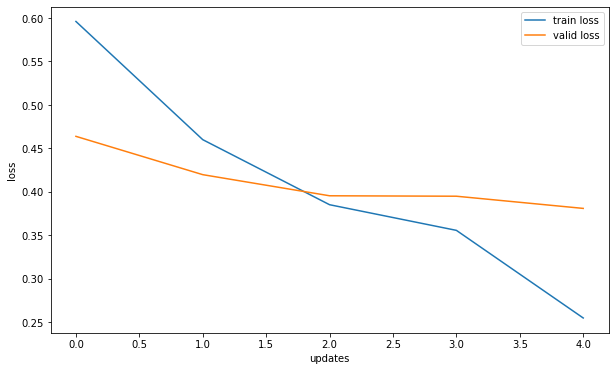

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

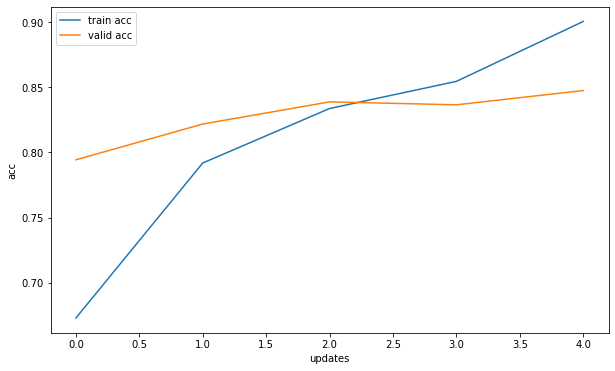

In [49]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [50]:
model.load_state_dict(torch.load('models/fasttext.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.369 | Test Acc: 84.37%


### Test on some random reviews

In [51]:
test_str = "This is Chaky.  This movie is really good good good"
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([68, 11,  0,  6,  0, 68, 24, 11, 79, 62, 62, 62], device='cuda:0')

In [52]:
text = text.reshape(1, -1)  #because batch_size is 1

In [53]:
text_length = torch.tensor([text.size(0)]).to(dtype=torch.int64)

In [54]:
text.shape

torch.Size([1, 12])

In [55]:
text_length.shape

torch.Size([1])

In [56]:
def predict(text, text_pipeline):
    model.eval()
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(output))
        return rounded_preds

In [57]:
predict(text, text_pipeline)  #accurate!

tensor([1.], device='cuda:0')

### Practice

- Try to turn off FastText embedding and see the accuracy.  For me, the accuracy reduced by around 10 to 20%
- Try to change Adam back to SGD.
- Try not to pack sequence and see what happens
- Try change your personal review and see whether your model can do well

### Trivials

If you don't like to pad, you can either use batch_size=1, or group samples by length.

Next class, let's try LSTM which is a better variant of RNN and see whether the accuracy improves.